In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("LunarLander-v3",render_mode='rgb_array',continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [3]:
pip install gymnasium

In [4]:
pip install swig

In [5]:
pip install "gymnasium[box2d]"

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, n_actions)

   
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [8]:

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
          
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_rwd = []


def plot_durations(show_result=False):
    plt.figure(1)
    rwd_t = torch.tensor(episode_rwd, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rwd_t.numpy())
    plt.pause(0.001) 
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
 
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

   
    state_action_values = policy_net(state_batch).gather(1, action_batch)

  
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

   
    loss = F.mse_loss(state_action_values.to(torch.float32), expected_state_action_values.unsqueeze(1).to(torch.float32))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    #torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


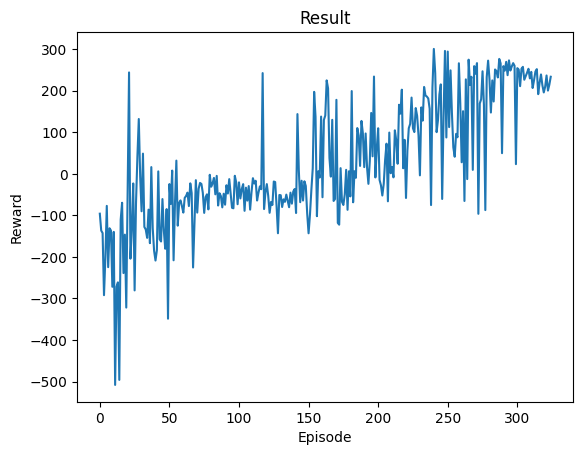

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 325
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    rwd=0
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        rwd+=reward.item()
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # screen = env.render()
        # screen = np.array(screen)
        # plt.figure()
        # plt.imshow(screen)
        # plt.title(f'Episode: {i_episode}, Timestep: {t},reward:{rwd}')
        # plt.plot()
        # plt.pause(0.0001)
        # if is_ipython:
        #     display.clear_output(wait=True)

        if done:
            episode_rwd.append(rwd)
           # print(f'Episode: {i_episode}, duration: {t+1},reward:{rwd}')
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [23]:


model = policy_net


torch.save(model, 'dqn_model2.pth')


torch.save(model.state_dict(), 'dqn_model_state_dict2.pth')

In [ ]:
import time
e, r = [], []
env = gym.make("LunarLander-v3",render_mode='rgb_array',continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
for i_episode in range(1, 100):
    state, __ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    score = 0

    while True:
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)

        observation, reward, terminated, truncated, _ = env.step(action.item())
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        state = next_state

        score += reward

        if terminated or truncated:
            break

    e.append(i_episode)
    r.append(score)





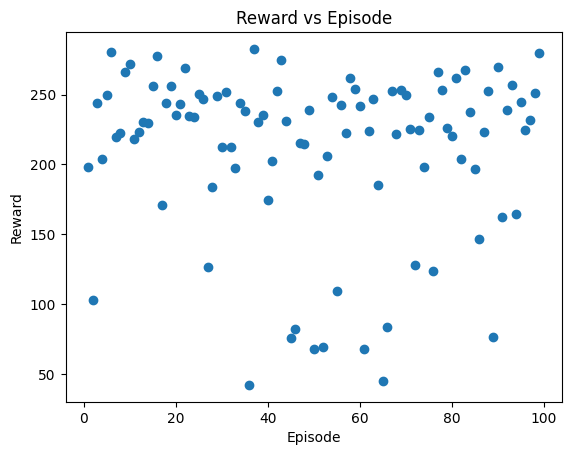

In [26]:
plt.scatter(e, r)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs Episode')
plt.show()